# **Early-Fusion_Mask**<br/>
**Master's Degree in Data Science (A.Y. 2023/2024)**<br/>
**University of Milano - Bicocca**<br/>

Valentina Barbera, Vittorio Haardt, Luca Porcelli, Luca Sinanaj

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Progetto/Data.zip" -d Data

Streaming output truncated to the last 5000 lines.
  inflating: Data/Data/TCGA-CS-6188/flair_78.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_79.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_82.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_83.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_85.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_89.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_92.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/flair_94.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_57.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_58.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_63.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_65.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_67.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_68.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_73.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_75.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_78.nii.gz  
  inflating: Data/Data/TCGA-CS-6188/t1_79.nii.gz  
  infla

In [ ]:
#!unzip "/content/drive/MyDrive/Medical Imaging & Big Data/Progetto/Data.zip" -d Data

# Installing packages and loading libraries

In [3]:
from torch.utils.data import DataLoader
import torch
import sys
#sys.path.append('/content/drive/MyDrive/Medical Imaging & Big Data/Progetto')
sys.path.append('/content/drive/MyDrive/Progetto')
from dataset import BraTS
import numpy as np
import random
from glob import glob
import torchvision.transforms as transforms
from unet_model_EF import UNet
from torch.nn import functional as F
from tqdm import tqdm

import os
import logging
from time import time
from os.path import dirname as up
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, jaccard_score
import matplotlib.pyplot as plt
import albumentations as A

# Seed

In [4]:
def seed_all(seed):
    # Pytorch Reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    # DataLoader Workers Reproducibility
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Data

### Reproducibility

In [5]:
seed_all(0)
g=torch.Generator()
g.manual_seed(0)

### Construct Data loader

In [6]:
dataset_train = BraTS("/content/Data/Data", 'train', True)
dataset_val = BraTS("/content/Data/Data", 'val', True)

Loading val data: 100%|██████████| 34/34 [00:09<00:00,  3.50it/s]


In [ ]:
dataset_test = BraTS("/content/Data/Data", 'test', True)

Loading test data: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]


In [ ]:
train_loader = DataLoader(dataset_train,
                          batch_size = 5,
                          shuffle = True,
                          num_workers = 0,           # 0 is the main process
                          pin_memory = False,        # Use pinned memory or not
                          persistent_workers= False, # This allows to maintain the workers Dataset instances alive.
                          worker_init_fn=seed_worker,
                          generator=g,
                          drop_last=True)

In [ ]:
val_loader = DataLoader(dataset_val,
                          batch_size = 5,
                          shuffle = False,
                          num_workers = 0,           # 0 is the main process
                          pin_memory = False,        # Use pinned memory or not
                          persistent_workers= False, # This allows to maintain the workers Dataset instances alive.
                          worker_init_fn=seed_worker,
                          generator=g)

In [ ]:
test_loader = DataLoader(dataset_test,
                          batch_size = 1,
                          shuffle = False)

# GPU presence check

In [ ]:
# Use gpu or cpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# 5 are the number of input bands and 4 are the classes including the background
model = UNet(5, 4)

model.to(device)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

# Training

### Cross Entropy Loss & adam optimizer

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Learning Rate scheduler

In [ ]:
reduce_lr_on_plateau=0
if reduce_lr_on_plateau==1:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
else:
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, '[45,65]', gamma=0.1)

### Start training

In [ ]:
epochs = 100
eval_every = 1

In [ ]:
# Train
model.train()

train_losses = []  # List to record training losses
val_losses = []    # List to record validation losses

for epoch in tqdm(range(1, epochs + 1)):
    training_loss = []
    training_batches = 0
    for it, (image, target) in enumerate(train_loader):

        image = image.to(device)
        target = target.to(device).long()

        optimizer.zero_grad()  # Resets gradients
        logits2 = F.upsample(input=model(image), size=image.size()[2:4], mode='bilinear')  # Runs the model
        loss = criterion(logits2, target)  # Computes the loss function

        loss.backward()  # Computes gradients
        training_batches += target.shape[0]  # Updates the count of training batches
        training_loss.append((loss.data * target.shape[0]).tolist())  # Records the loss multiplied by the number of elements in the current batch
        torch.nn.utils.clip_grad_norm_(model.parameters(), float('inf'))  # Applies gradient clipping
        optimizer.step()  # Updates model weights using the optimizer

    print("Training loss was: " + str(sum(training_loss) / training_batches))  # Prints the average training loss per epoch
    train_losses.append(sum(training_loss) / training_batches)  # Records the average training loss per epoch in the list

    # Saves the model
    model_dir = os.path.join(os.path.join(up(os.path.abspath("/content/drive/MyDrive/Progetto/results")), 'trained_models_EF_mask'), str(epoch))
    os.makedirs(model_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(model_dir, 'model.pth'))

    if epoch % eval_every == 0 or epoch == 1:  # Evaluates the model on validation data
        model.eval()
        val_loss = []
        val_batches = 0
        y_true_val = []
        y_predicted_val = []
        seed_all(0)
        with torch.no_grad():
            for (image, target) in val_loader:

                image = image.to(device)
                target = target.to(device).long()

                logits = model(image)  # Runs the model
                logits = F.upsample(input=logits, size=(target.shape[-2], target.shape[-1]), mode='bilinear')  # Bilinear upsampling of logits
                loss = criterion(logits, target)  # Computes the loss function

                logits = torch.movedim(logits, (0, 1, 2, 3), (0, 3, 1, 2))  # Moves dimensions to compute probabilities
                logits = logits.reshape((-1, 4))  # Reshapes logits
                target = target.reshape(-1)  # Reshapes targets
                mask = target != 0  # Creates a mask for non-empty targets

                logits = logits[mask]
                target = target[mask]

                probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()  # Computes probabilities
                target = target.cpu().numpy()
                val_batches += target.shape[0]  # Updates the count of validation batches
                val_loss.append((loss.data * target.shape[0]).tolist())  # Records the loss multiplied by the number of elements in the current batch
                y_predicted_val += probs.argmax(1).tolist()  # Adds predictions to the list
                y_true_val += target.tolist()  # Adds true targets to the list

            y_predicted_val = np.asarray(y_predicted_val)
            y_true_val = np.asarray(y_true_val)
            subset_acc = accuracy_score(y_true_val, y_predicted_val)  # Computes accuracy
            print("Acc" + str(subset_acc))  # Prints accuracy

        val_losses.append(sum(val_loss) / val_batches)  # Records the average validation loss per epoch in the list
        scheduler.step()  # Updates the scheduler
        model.train()  # Restores the model to training mode

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 1.132459014245319


  1%|          | 1/100 [01:14<2:03:01, 74.56s/it]

Acc0.0


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.9728084278450976


  2%|▏         | 2/100 [02:29<2:02:11, 74.81s/it]

Acc0.0


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8876843586725448


  3%|▎         | 3/100 [03:44<2:00:49, 74.73s/it]

Acc0.0


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.844658224677351


  4%|▍         | 4/100 [04:59<1:59:52, 74.92s/it]

Acc0.0


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.8204110248854874


  5%|▌         | 5/100 [06:14<1:58:26, 74.81s/it]

Acc0.0


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.805670701897962


  6%|▌         | 6/100 [07:29<1:57:23, 74.93s/it]

Acc0.001690498053378966


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7955367374075879


  7%|▋         | 7/100 [08:43<1:55:57, 74.82s/it]

Acc0.1353348646003488


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7886793544576487


  8%|▊         | 8/100 [09:58<1:54:44, 74.83s/it]

Acc0.2426093619212074


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7847688440811763


  9%|▉         | 9/100 [11:13<1:53:18, 74.71s/it]

Acc0.11368318667089364


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7814125343350297


 10%|█         | 10/100 [12:27<1:51:58, 74.65s/it]

Acc0.3124432577461005


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7789128687407566


 11%|█         | 11/100 [13:42<1:50:49, 74.71s/it]

Acc0.3446110947464987


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7773783210382564


 12%|█▏        | 12/100 [14:57<1:49:44, 74.82s/it]

Acc0.16030361586908617


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7755179274383435


 13%|█▎        | 13/100 [16:12<1:48:30, 74.83s/it]

Acc0.2310583450741029


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7744448382931927


 14%|█▍        | 14/100 [17:27<1:47:12, 74.79s/it]

Acc0.29561170201278975


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7733623261916508


 15%|█▌        | 15/100 [18:41<1:45:58, 74.81s/it]

Acc0.4189860985257164


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7718852809189889


 16%|█▌        | 16/100 [19:56<1:44:44, 74.81s/it]

Acc0.42817024533385395


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7708486007869458


 17%|█▋        | 17/100 [21:11<1:43:32, 74.85s/it]

Acc0.35975819917470525


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7705093507732295


 18%|█▊        | 18/100 [22:26<1:42:15, 74.82s/it]

Acc0.3122964081451427


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7689566180163773


 19%|█▉        | 19/100 [23:41<1:40:56, 74.78s/it]

Acc0.404689857961883


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7684893148470441


 20%|██        | 20/100 [24:56<1:39:49, 74.87s/it]

Acc0.30906658074525306


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7674159404603152


 21%|██        | 21/100 [26:11<1:38:37, 74.90s/it]

Acc0.44187390456676345


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7660040877786354


 22%|██▏       | 22/100 [27:25<1:37:17, 74.85s/it]

Acc0.3750953442629748


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7649498519484317


 23%|██▎       | 23/100 [28:40<1:35:58, 74.79s/it]

Acc0.24748217720946022


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7652808919280014


 24%|██▍       | 24/100 [29:55<1:34:43, 74.78s/it]

Acc0.4438460083255086


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7652026722147146


 25%|██▌       | 25/100 [31:09<1:33:25, 74.74s/it]

Acc0.47291877403042554


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.763424691052213


 26%|██▌       | 26/100 [32:25<1:32:19, 74.86s/it]

Acc0.45369961654977725


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7636400475829087


 27%|██▋       | 27/100 [33:39<1:31:05, 74.86s/it]

Acc0.43096988978505535


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7628078440036153


 28%|██▊       | 28/100 [34:55<1:29:56, 74.96s/it]

Acc0.40233853670419395


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7623273518972018


 29%|██▉       | 29/100 [36:10<1:28:40, 74.94s/it]

Acc0.5051505337982994


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7618421929837995


 30%|███       | 30/100 [37:25<1:27:38, 75.12s/it]

Acc0.41824925905738103


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7614202310031932


 31%|███       | 31/100 [38:40<1:26:22, 75.10s/it]

Acc0.5084943855942269


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7606831044496613


 32%|███▏      | 32/100 [39:55<1:25:08, 75.12s/it]

Acc0.459157238778315


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7610247400263156


 33%|███▎      | 33/100 [41:10<1:23:54, 75.14s/it]

Acc0.46699468836355124


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7601873590627732


 34%|███▍      | 34/100 [42:25<1:22:33, 75.06s/it]

Acc0.4069254271811701


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7604344254366328


 35%|███▌      | 35/100 [43:41<1:21:25, 75.16s/it]

Acc0.45103386438180204


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7593876873112758


 36%|███▌      | 36/100 [44:57<1:20:25, 75.40s/it]

Acc0.39874417676545615


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7593361747824328


 37%|███▋      | 37/100 [46:12<1:19:13, 75.45s/it]

Acc0.34288172473992506


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7589376335970331


 38%|███▊      | 38/100 [47:27<1:17:45, 75.25s/it]

Acc0.4541116592536412


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7579528116577369


 39%|███▉      | 39/100 [48:42<1:16:29, 75.24s/it]

Acc0.4620285803876311


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7576722525517433


 40%|████      | 40/100 [49:57<1:15:08, 75.14s/it]

Acc0.4453456018976424


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7581423790446258


 41%|████      | 41/100 [51:12<1:13:49, 75.08s/it]

Acc0.42395998089227543


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7578311417507351


 42%|████▏     | 42/100 [52:27<1:12:29, 75.00s/it]

Acc0.5230091729171328


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7572602523363023


 43%|████▎     | 43/100 [53:42<1:11:17, 75.04s/it]

Acc0.44171755293280246


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7564568657306988


 44%|████▍     | 44/100 [54:58<1:10:10, 75.19s/it]

Acc0.5083086640400744


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7569594570876028


 45%|████▌     | 45/100 [56:13<1:08:57, 75.23s/it]

Acc0.48461923194203416


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.756416016795575


 46%|████▌     | 46/100 [57:28<1:07:40, 75.19s/it]

Acc0.5111946906094863


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7565319300558593


 47%|████▋     | 47/100 [58:43<1:06:28, 75.25s/it]

Acc0.5647084128408746


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7553311513219069


 48%|████▊     | 48/100 [59:59<1:05:12, 75.23s/it]

Acc0.5245001282774455


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7555745940776508


 49%|████▉     | 49/100 [1:01:14<1:04:02, 75.35s/it]

Acc0.3899141966419815


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.755905667453036


 50%|█████     | 50/100 [1:02:30<1:02:46, 75.34s/it]

Acc0.5267365613179147


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7549012905423822


 51%|█████     | 51/100 [1:03:45<1:01:34, 75.40s/it]

Acc0.48483345959519614


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7548743623258405


 52%|█████▏    | 52/100 [1:05:00<1:00:18, 75.38s/it]

Acc0.49472853123620586


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7545352684461684


 53%|█████▎    | 53/100 [1:06:16<59:05, 75.44s/it]  

Acc0.48706730117211894


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7545357361597275


 54%|█████▍    | 54/100 [1:07:31<57:46, 75.35s/it]

Acc0.5178901685919801


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7541132167788619


 55%|█████▌    | 55/100 [1:08:47<56:32, 75.39s/it]

Acc0.5335944376826441


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7536485505017994


 56%|█████▌    | 56/100 [1:10:02<55:15, 75.35s/it]

Acc0.53106862454617


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.753681601341881


 57%|█████▋    | 57/100 [1:11:17<54:00, 75.36s/it]

Acc0.47712126408136507


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7535023923385015


 58%|█████▊    | 58/100 [1:12:32<52:40, 75.25s/it]

Acc0.504246976841818


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7535800286578788


 59%|█████▉    | 59/100 [1:13:48<51:27, 75.31s/it]

Acc0.5356684723408777


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7536614249329274


 60%|██████    | 60/100 [1:15:03<50:08, 75.22s/it]

Acc0.49133198634817005


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7536797242904828


 61%|██████    | 61/100 [1:16:18<48:55, 75.28s/it]

Acc0.5282525674925085


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7533566874287189


 62%|██████▏   | 62/100 [1:17:33<47:38, 75.22s/it]

Acc0.4919021083283592


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7534201844074235


 63%|██████▎   | 63/100 [1:18:48<46:23, 75.23s/it]

Acc0.41631775489419487


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7528028594888074


 64%|██████▍   | 64/100 [1:20:03<45:05, 75.15s/it]

Acc0.5273852910256753


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.752600935133786


 65%|██████▌   | 65/100 [1:21:19<43:51, 75.18s/it]

Acc0.5180577499013085


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7524461226342818


 66%|██████▌   | 66/100 [1:22:33<42:32, 75.07s/it]

Acc0.49421542145403563


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7533170868773753


 67%|██████▋   | 67/100 [1:23:48<41:16, 75.04s/it]

Acc0.5335210128821652


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.752586585950335


 68%|██████▊   | 68/100 [1:25:03<39:59, 74.99s/it]

Acc0.5389501290116936


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7533021148791812


 69%|██████▉   | 69/100 [1:26:18<38:44, 74.99s/it]

Acc0.5246392034877644


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7521411413750494


 70%|███████   | 70/100 [1:27:33<37:29, 74.97s/it]

Acc0.5457492655360399


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7518297451928204


 71%|███████   | 71/100 [1:28:48<36:15, 75.00s/it]

Acc0.5301270594576758


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7518761528097766


 72%|███████▏  | 72/100 [1:30:03<34:58, 74.96s/it]

Acc0.5892875807564828


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7518455183462976


 73%|███████▎  | 73/100 [1:31:18<33:44, 74.99s/it]

Acc0.4840231953263819


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7520990855426994


 74%|███████▍  | 74/100 [1:32:33<32:28, 74.95s/it]

Acc0.6091546041237096


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7516709472298192


 75%|███████▌  | 75/100 [1:33:48<31:14, 74.99s/it]

Acc0.5776812793537236


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7514750256865463


 76%|███████▌  | 76/100 [1:35:03<29:58, 74.94s/it]

Acc0.5237606973455639


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7524088449856865


 77%|███████▋  | 77/100 [1:36:18<28:44, 74.97s/it]

Acc0.593091849242472


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7515770653955343


 78%|███████▊  | 78/100 [1:37:33<27:27, 74.90s/it]

Acc0.5899198978617834


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7515010651268254


 79%|███████▉  | 79/100 [1:38:48<26:14, 74.98s/it]

Acc0.5620875793743688


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.750920144229159


 80%|████████  | 80/100 [1:40:03<24:57, 74.88s/it]

Acc0.576513393115518


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7513384180378828


 81%|████████  | 81/100 [1:41:18<23:43, 74.94s/it]

Acc0.615996067885979


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7513118287716531


 82%|████████▏ | 82/100 [1:42:33<22:28, 74.91s/it]

Acc0.5848078041060876


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7515987974641986


 83%|████████▎ | 83/100 [1:43:47<21:13, 74.92s/it]

Acc0.5507577007498832


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7514138144276202


 84%|████████▍ | 84/100 [1:45:02<19:57, 74.84s/it]

Acc0.5809162896807057


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7511096076414473


 85%|████████▌ | 85/100 [1:46:17<18:43, 74.89s/it]

Acc0.593488343165058


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7510366384733455


 86%|████████▌ | 86/100 [1:47:32<17:26, 74.78s/it]

Acc0.5615900183734766


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7507502194346073


 87%|████████▋ | 87/100 [1:48:46<16:12, 74.80s/it]

Acc0.5790867164170079


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7512667521672989


 88%|████████▊ | 88/100 [1:50:01<14:56, 74.71s/it]

Acc0.6286294526742608


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7514418860204813


 89%|████████▉ | 89/100 [1:51:16<13:42, 74.77s/it]

Acc0.5528256886598419


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.750532903740122


 90%|█████████ | 90/100 [1:52:30<12:26, 74.69s/it]

Acc0.5927333634518985


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7510168459441258


 91%|█████████ | 91/100 [1:53:45<11:12, 74.69s/it]

Acc0.5338674051761892


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7509839319580298


 92%|█████████▏| 92/100 [1:55:00<09:57, 74.66s/it]

Acc0.6195265050572412


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7505703729842974


 93%|█████████▎| 93/100 [1:56:15<08:43, 74.73s/it]

Acc0.6351469834932411


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.750609608247392


 94%|█████████▍| 94/100 [1:57:29<07:28, 74.74s/it]

Acc0.6609208161037


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7504219380526767


 95%|█████████▌| 95/100 [1:58:44<06:13, 74.74s/it]

Acc0.613397693770208


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7511105628650542


 96%|█████████▌| 96/100 [1:59:59<04:58, 74.66s/it]

Acc0.6007556707701053


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7502103755620413


 97%|█████████▋| 97/100 [2:01:13<03:44, 74.67s/it]

Acc0.609035396800579


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.750057762538483


 98%|█████████▊| 98/100 [2:02:28<02:29, 74.73s/it]

Acc0.6590774217010885


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7499249449705819


 99%|█████████▉| 99/100 [2:03:43<01:14, 74.67s/it]

Acc0.577207041524748


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training loss was: 0.7502088615610281


100%|██████████| 100/100 [2:04:57<00:00, 74.98s/it]

Acc0.6031804168282732


### Loss visualization for epochs

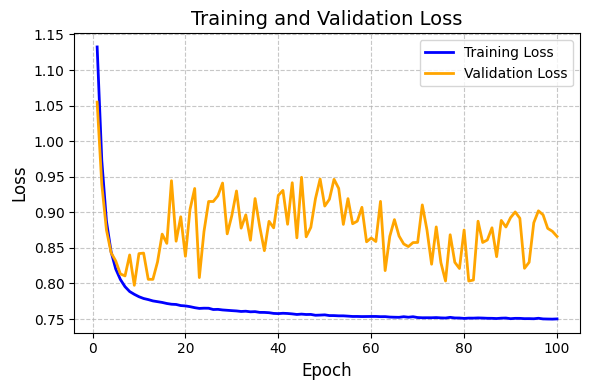

In [ ]:
plt.figure(figsize=(6, 4))

epochs = len(train_losses)

plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='orange', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

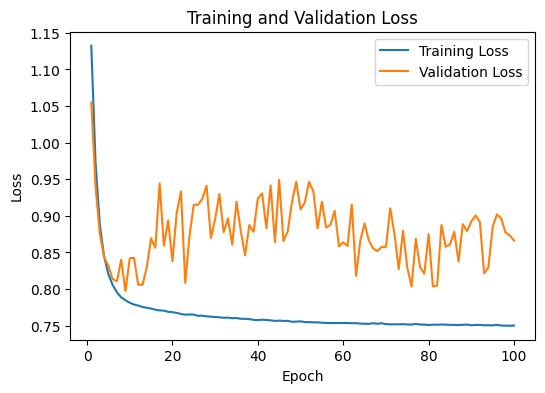

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test

### Loading model

In [ ]:
models_list = []
models_files = glob(os.path.join(os.path.join("/content/drive/MyDrive/Progetto/trained_models_EF_mask/", '100'),'*.pth'))

for model_file in models_files:

    model = UNet(5, 4)

    model.to(device)

    # Load model from specific epoch to continue the training or start the evaluation
    checkpoint = torch.load(model_file, map_location = device)
    checkpoint = {k.replace('decoder','decode_head'):v for k,v in checkpoint.items() if ('proj1' not in k) and ('proj2' not in k)}

    # Modify keys in the loaded checkpoint dictionary to match the model's expected keys
    checkpoint = {k.replace('decode_head', 'decoder'): v for k, v in checkpoint.items()}

    # Load the modified state dictionary into the model
    model.load_state_dict(checkpoint)

    del checkpoint  # dereference
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model.eval()

    models_list.append(model)

### Evaluation

In [ ]:
a=[]
b=[]
inputs_list = []
y_true = []
y_predicted = []

In [ ]:
def dice_coefficient_multiclass(y_true, y_pred, num_classes):
    dice_scores = []
    for class_label in range(1, num_classes):
        y_true_class = [1 if x == class_label else 0 for x in y_true]
        y_pred_class = [1 if x == class_label else 0 for x in y_pred]
        intersection = sum(y_true_class[i] * y_pred_class[i] for i in range(len(y_true)))
        union = sum(y_true_class) + sum(y_pred_class)
        dice = (2. * intersection) / (union)
        dice_scores.append(dice)
    return dice_scores

In [ ]:
with torch.no_grad():
    for (image, target) in tqdm(test_loader, desc="testing"):
        image = image.to(device)
        target = target.to(device)
        seed_all(0)

        all_predictions = []
        logits = model(image)  # Forward pass to get logits from the model

        im_input = (image[0].detach().cpu().numpy())  # Convert the first image to a numpy array and detach from the computation graph
        inputs_list.append(im_input)  # Append the input image to a list (for visualization)

        # Accuracy metrics only on annotated pixels
        probs = torch.nn.functional.softmax(logits, dim=1)  # Compute softmax probabilities from logits
        predictions = probs.argmax(1)  # Get the class predictions by selecting the index of the maximum probability
        predictions = predictions.reshape(-1)  # Reshape predictions to a 1D array

        a.append(target.cpu().numpy())
        b.append(predictions.cpu().numpy())

        target = target.reshape(-1)  # Reshape true targets to a 1D array
        mask = target != 0  # Create a mask for non-zero targets
        predictions = predictions[mask].cpu().numpy()  # Apply the mask to predictions and convert to numpy array
        target = target[mask]  # Apply the mask to true targets
        target = target.cpu().numpy()  # Convert true targets to numpy array
        y_predicted += predictions.tolist()  # Add predictions to the list 'y_predicted'
        y_true += target.tolist()  # Add true targets to the list 'y_true'

    # Calculate and print scores
    subset_acc = accuracy_score(y_true, y_predicted)  # Compute subset accuracy
    iou_acc = jaccard_score(y_true, y_predicted, average='macro')  # Compute IoU
    dice_coeff = dice_coefficient_multiclass(y_true, y_predicted, 4)  # Compute Dice coefficient
    print("accuracy_score: " + str(subset_acc))
    print("IoU: " + str(iou_acc))
    print("Dice coefficient: class1: " + str(dice_coeff[0]) + " class2: " + str(dice_coeff[1]) + " class3: " + str(dice_coeff[2]))

testing: 100%|██████████| 817/817 [00:13<00:00, 60.09it/s]


accuracy_score: 0.5419612423170954
IoU: 0.2702751469290968
Dice coefficient: class1: 0.41669900739534693 class2: 0.674469568743338 class3: 0.4722176044715888


### Visual evaluation

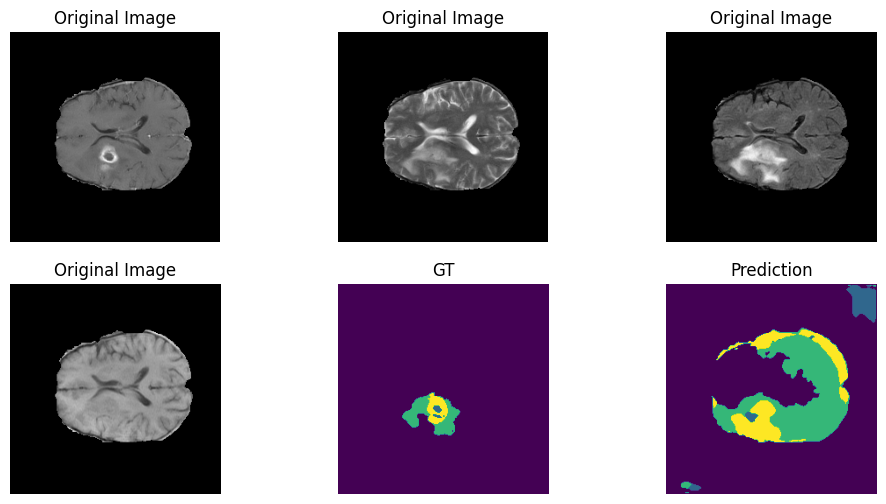

In [ ]:
n = 20

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0, 0].imshow(inputs_list[n][0,:,:], cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')
axes[0, 1].imshow(inputs_list[n][1,:,:], cmap='gray')
axes[0, 1].set_title('Original Image')
axes[0, 1].axis('off')
axes[0, 2].imshow(inputs_list[n][2,:,:], cmap='gray')
axes[0, 2].set_title('Original Image')
axes[0, 2].axis('off')
axes[1, 0].imshow(inputs_list[n][3,:,:], cmap='gray')
axes[1, 0].set_title('Original Image')
axes[1, 0].axis('off')


axes[1, 1].imshow(np.resize(a[n], (240, 240)))
axes[1, 1].set_title('GT')
axes[1, 1].axis('off')
axes[1, 2].imshow(np.resize(b[n], (240, 240)))
axes[1, 2].set_title('Prediction')
axes[1, 2].axis('off')
plt.show()